C:\Users\tobia\AppData\Local\Temp\ipykernel_15852\2124146124.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour_sin'] = np.sin(2 * np.pi * df_filtered['hourOfDay'] / 24)
C:\Users\tobia\AppData\Local\Temp\ipykernel_15852\2124146124.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['hour_cos'] = np.cos(2 * np.pi * df_filtered['hourOfDay'] / 24)


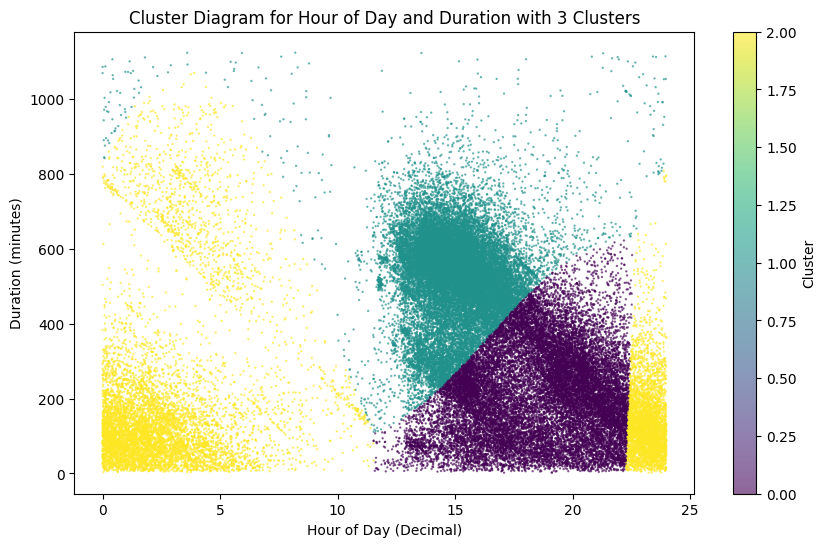

        duration         hour_circular_mean
            mean     std               mean
cluster                                    
0         217.43  118.35                NaN
1         533.79  115.68               11.6
2         181.99  190.59                NaN


C:\Users\tobia\AppData\Local\Temp\ipykernel_15852\2124146124.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['hour_circular_mean'] = df_filtered.groupby('cluster').apply(


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# load data
file_path = "../data/processed/charging_sessions_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

# Feature engineering
df['duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 60  # Duration in minutes
df['hourOfDay'] = df['connectionTime'].dt.hour + df['connectionTime'].dt.minute / 60  # Decimal hours

# Remove outliers for 'duration' using IQR method
Q1_duration = df['duration'].quantile(0.25)
Q3_duration = df['duration'].quantile(0.75)
IQR_duration = Q3_duration - Q1_duration
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

df_filtered = df[(df['duration'] >= lower_bound_duration) & (df['duration'] <= upper_bound_duration)]

# Cyclical transformation of the hour of day (sin and cos)
df_filtered['hour_sin'] = np.sin(2 * np.pi * df_filtered['hourOfDay'] / 24)
df_filtered['hour_cos'] = np.cos(2 * np.pi * df_filtered['hourOfDay'] / 24)

# Data for clustering: Duration and cyclical transformation of the hour of day
features = ['duration', 'hour_sin', 'hour_cos']

# Filter out NaN values
df_filtered = df_filtered[features + ['hourOfDay']].dropna()

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_filtered[['duration', 'hour_sin', 'hour_cos']])

# KMeans clustering with 4 clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(scaled_features)

# 2D plot of the clustering results (hour of day vs. duration)
plt.figure(figsize=(10, 6))

# Plot for hourOfDay on the x-axis and duration on the y-axis
plt.scatter(df_filtered['hourOfDay'], df_filtered['duration'], c=df_filtered['cluster'], cmap='viridis', alpha=0.6, s=.5)


# Add labels
plt.xlabel('Hour of Day (Decimal)')
plt.ylabel('Duration (minutes)')
plt.title(f'Cluster Diagram for Hour of Day and Duration with {n_clusters} Clusters')

# Add color legend
plt.colorbar(label='Cluster')

# Show the plot
plt.show()

# Function to calculate the circular mean for 'hourOfDay' within each cluster
def calculate_circular_mean(hour_sin, hour_cos):
    mean_sin = np.mean(hour_sin)
    mean_cos = np.mean(hour_cos)
    mean_angle = np.arctan2(mean_sin, mean_cos)
    mean_hour = (mean_angle * 24 / (2 * np.pi)) % 24
    return mean_hour

# Calculate circular mean for each cluster
df_filtered['hour_circular_mean'] = df_filtered.groupby('cluster').apply(
    lambda group: calculate_circular_mean(group['hour_sin'], group['hour_cos'])
).reset_index(level=0, drop=True)

# Output cluster statistics
cluster_stats = df_filtered.groupby('cluster').agg({
    'duration': ['mean', 'std'],
    'hour_circular_mean': ['mean']
}).round(2)

print(cluster_stats)


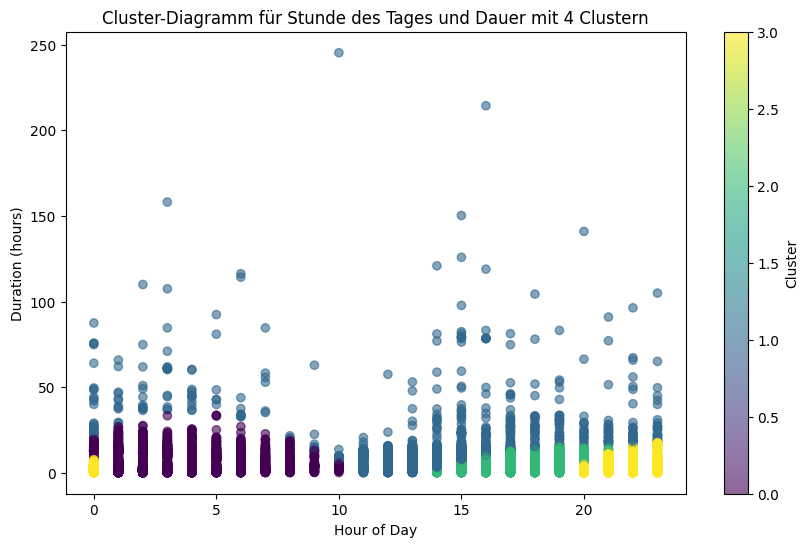

        duration       hour_circular_mean
            mean   std               mean
cluster                                  
0           4.34  4.96                NaN
1           9.24  5.45              13.86
2           5.26  2.76                NaN
3           2.85  1.91                NaN


C:\Users\tobia\AppData\Local\Temp\ipykernel_8316\644972585.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['hour_circular_mean'] = df_filtered.groupby('cluster').apply(


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# CSV-Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])

# Feature-Engineering
df['duration'] = (df['disconnectTime'] - df['connectionTime']).dt.total_seconds() / 3600  # Dauer in Stunden
df['hourOfDay'] = df['connectionTime'].dt.hour

# Zyklische Transformation der Stunde (sin und cos)
df['hour_sin'] = np.sin(2 * np.pi * df['hourOfDay'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hourOfDay'] / 24)

# Daten für Clustering: Dauer und zyklische Transformation der Stunde
features = ['duration', 'hour_sin', 'hour_cos']

# Filtere NaN-Werte
df_filtered = df[features + ['hourOfDay']].dropna()  # Hier fügen wir 'hourOfDay' hinzu

# Skalierung der Daten
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_filtered[['duration', 'hour_sin', 'hour_cos']])

# KMeans-Clustering mit 4 Clustern
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(scaled_features)

# 2D-Plot der Cluster-Ergebnisse (Stunde des Tages vs. Dauer)
plt.figure(figsize=(10, 6))

# Plot für hourOfDay auf der x-Achse und Dauer auf der y-Achse
# Hier verwenden wir 'hourOfDay', aber die Punkte werden zyklisch angezeigt
plt.scatter(df_filtered['hourOfDay'], df_filtered['duration'], c=df_filtered['cluster'], cmap='viridis', alpha=0.6)

# Hinzufügen der Labels
plt.xlabel('Hour of Day')
plt.ylabel('Duration (hours)')
plt.title(f'Cluster-Diagramm für Stunde des Tages und Dauer mit {n_clusters} Clustern')

# Hinzufügen der Farblegende
plt.colorbar(label='Cluster')

# Anzeigen
plt.show()

# Berechnung des Circular Mean für 'hourOfDay' innerhalb jedes Clusters
def calculate_circular_mean(hour_sin, hour_cos):
    mean_sin = np.mean(hour_sin)
    mean_cos = np.mean(hour_cos)
    mean_angle = np.arctan2(mean_sin, mean_cos)
    mean_hour = (mean_angle * 24 / (2 * np.pi)) % 24
    return mean_hour

# Cluster-Statistiken mit circular mean
df_filtered['hour_circular_mean'] = df_filtered.groupby('cluster').apply(
    lambda group: calculate_circular_mean(group['hour_sin'], group['hour_cos'])
).reset_index(level=0, drop=True)

# Ausgabe der Cluster-Statistiken
cluster_stats = df_filtered.groupby('cluster').agg({
    'duration': ['mean', 'std'],
    'hour_circular_mean': ['mean']
}).round(2)

print(cluster_stats)
